This is the PyTorch version of FEA-Net trying to implement the forward prediction step by directly using the FEA filter.

Some of the codes comes from:  
[1] https://github.com/ymlasu/FEA-Net   
[2] https://zenodo.org/record/2660730   

In [1]:
import numpy as np

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import reduce

In [3]:
D = 1 # diffusity
nstep = 60 # number of time steps
dt = 1/nstep 

In [4]:
def apply_n_times(f, n):
    """Returns a new function which is f folded n times: f(f(f(f(...f(f(n))...))))

    Usage
    -----

    apply_n_times(lambda x: x**2, 3)(2) == 256
    """

    def f_folded_n_times(x):
        return reduce(lambda fx, _: f(fx), range(n), x)
    return f_folded_n_times

In [5]:
def normal_distributed_tensor(size, dtype=torch.float32, requires_grad=False):
    return torch.tensor(np.random.normal(size=(size, size)).reshape((1, 1, size, size)),
                        dtype=dtype,
                        requires_grad=requires_grad)

In [6]:
def _reset_boundary_(u, boundary_index, boundary_values):
    """ Reset values at the boundary of the domain


    Parameters
    ----------
    u : tensor-like, shape = [*, *, n, n]
        variable to reset.

    boundary_index : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: 1.0 for inner points 0.0 elsewhere.

    boundary_values : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: desired values for boundary points 0.0 elsewhere.

    Returns
    -------
    u : tensor-like, shape = [*, *, n, n]
        resetted values.


    """

    return u * boundary_index + boundary_values

In [7]:
def _jacobi_iteration_step_(u, boundary_index, boundary_values, forcing_term):
    """ Jacobi method iteration step, defined as a convolution.
    Resets the boundary.


    Parameters
    ----------
    u : tensor-like, shape = [*, *, n, n]
        variable to reset.

    boundary_index : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: 1.0 for inner points 0.0 elsewhere.

    boundary_values : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: desired values for boundary points 0.0 elsewhere.

    forcing_term : tensor-like, shape = [*, *, n, n]
        matrix describing the forcing term (rhs, e.g., source term).


    Returns
    -------
    u : tensor-like, shape = [*, *, n, n]
        resetted values.
    """

    ''' Construct the stiffness neural network layer '''
    h = 1./(u.shape[-1]-1)
    Knet = nn.Conv2d(1, 1, 3, padding = 1, bias = False)    
    K_weights_np = np.array([[h*h/36.-D*dt/3., h*h/9.-D*dt/3., h*h/36.-D*dt/3.],
                            [h*h/9.-D*dt/3., 4.*h*h/9.+8*D*dt/3., h*h/9.-D*dt/3.],
                            [h*h/36.-D*dt/3., h*h/9.-D*dt/3., h*h/36.-D*dt/3.]], dtype=np.float32).reshape(1,1,3,3)
    # K_weights_np = np.array([[-D/3., -D/3., -D/3.],
    #                        [-D/3., 8*D/3., -D/3.],
    #                        [-D/3., -D/3., -D/3.]], dtype=np.float32).reshape(1,1,3,3)

    K_weights = torch.from_numpy(K_weights_np)
    Knet.weight = nn.Parameter(K_weights)

    # The final model will be defined as a convolutional network, but this step
    # is fixed.
    for param in Knet.parameters():
        param.requires_grad = False

    ''' Construct the forcing term neural network layer '''
    fnet = nn.Conv2d(1, 1, 3, padding = 1, bias = False)    
    f_weights_np = np.array([[h*h/36., h*h/9., h*h/36.],
                            [h*h/9., 4.*h*h/9., h*h/9.],
                            [h*h/36., h*h/9., h*h/36.]], dtype=np.float32).reshape(1,1,3,3)
    f_weights = torch.from_numpy(f_weights_np)
    fnet.weight = nn.Parameter(f_weights)

    # The final model will be defined as a convolutional network, but this step
    # is fixed.
    for param in fnet.parameters():
        param.requires_grad = False

    # note in case: if a.shape = (1,1,1,3), b.shape = (1,2,2,3), c = b/a
    # then c.shape = (1,2,2,3)

    # perform iteration step, u_new = omega/d_mat*residual + u
    # residual = f - K*u (* is convolution operator here)
    omega = 2/3.
    d_mat = K_weights[0,0,1,1] # d matrix is a scalar for static heat problem
    u_new = omega/d_mat*(fnet(forcing_term)-Knet(u))+u

    return _reset_boundary_(u_new, boundary_index, boundary_values)


In [8]:
def jacobi_method(boundary_index, boundary_values, forcing_term, initial_u = None, k = 1000):
    """ Compute jacobi method solution by convolution


    Parameters
    ----------
    boundary_index : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: 1.0 for inner points 0.0 elsewhere.

    boundary_values : tensor-like, shape = [*, *, n, n]
        matrix describing the domain: desired values for boundary points 0.0 elsewhere.

    forcing_term : tensor-like, shape = [*, *, n, n]
        matrix describing the forcing term.

    initial_u : tensor-like, shape = [*, *, n, n]
        Initial values.

    Returns
    -------
    u : tensor-like, shape = [*, *, n, n]
        solution matrix.
    """
    N = boundary_index.size()[3]

    if initial_u is None:
        u = torch.zeros(1, 1, N, N)
    else:
        u = initial_u

    u = _reset_boundary_(u, boundary_index, boundary_values)

    def step(u_k):
        return _jacobi_iteration_step_(u_k, boundary_index, boundary_values, forcing_term)

    return apply_n_times(step, k)(u)

In [9]:
# define two geometries
def square_geometry(size):
    """Defines a square geometry of given size (as a single positive integer)
    The boundary-values are set randomly from a uniform distribtion in the interval [-1, 1].

    Example:

    b1 b1 b2
    b4 0  b2
    b4 b3 b3

    Returns:
        (geometry, boundary_index)
    """

    # Define geometry, 1.0 inner points; 0.0 elsewhre
    B_idx = torch.ones(1, 1, size ,size )
    B_idx[0, 0,  0,  :] = torch.zeros(size)
    B_idx[0, 0, -1,  :] = torch.zeros(size)
    B_idx[0, 0,  :,  0] = torch.zeros(size)
    B_idx[0, 0,  :, -1] = torch.zeros(size)

    # Define boundary values
    B = torch.zeros_like(B_idx)

    '''
    # Randomly set the boundary values
    B[0, 0,  0, :] = np.random.uniform(-1, 1)
    B[0, 0,  :,-1] = np.random.uniform(-1, 1)
    B[0, 0, -1, :] = np.random.uniform(-1, 1)
    B[0, 0, 1:, 0] = np.random.uniform(-1, 1) # we don't want to overwrite the first value
    '''

    # Set the boundary value
    B[0, 0,  0, :] = 1.0
    #B[0, 0,  :,-1] = 0.0
    #B[0, 0, -1, :] = 0.0
    #B[0, 0, 1:, 0] = 0.0 

    return B_idx, B


def l_shaped_geometry(size, l_cutout_size=None):
    """Defines a L-shaped geometry of given size (as a single positive integer), and
    l_cutout_size (think of creating the L-shape as cutting out a smaller square piece)

    l_cutout_size is by default size/2

    Returns:
        (geometry, boundary_index)
    """

    l_cutout_size = l_cutout_size or int(np.floor(size / 2))

    B_idx, B = square_geometry(size)

    _, cutout = square_geometry(l_cutout_size)
    B[0, 0, :l_cutout_size, :l_cutout_size] = cutout
    B[0, 0, :l_cutout_size - 1, :l_cutout_size - 1] = np.random.uniform(0, 1)

    B_idx[0, 0, :l_cutout_size, :l_cutout_size] = torch.zeros(1)

    return B_idx, B

In [10]:
# define a problem class
class DirichletProblem:
    """Define a Dirichlet problem instance

    The groud truth solution is computed on instantiation.

    Parameters
    ----------
    B_idx : tensor-like, shape = [1, 1, N, N]
        variable to reset.

    B : tensor-like, shape = [1, 1, N, N], optional

    f : tensor-like, shape = [1, 1, N, N], optional
        variable to reset.

    k_ground_truth : int, optional, default 1000
        Number of iterations to used to obtain ground truth solution
        with Jacobi method.

    N  : int, optional, default 16
         Used to define the domain as....

    inital_u : tensor-like, shape = [1, 1, N, N], optional
               Default = torch.rand(1, 1, N, N, requires_grad=True)
               Initial solution

    inital_u_jacobi : tensor-like, shape = [1, 1, N, N], optional
               Default = torch.rand(1, 1, N, N, requires_grad=True)

    Returns
    -------
    self : object
        Returns an instance of self.
    """

    def __init__(self,
                 B_idx=None,
                 B=None,
                 f=None,
                 k_ground_truth=20000,
                 initial_ground_truth=None,
                 initial_u=None,
                 domain_type="square",
                 N=16):

        # Initialize Geometry and Boundary Conditions
        if B_idx is None:
            if domain_type.lower() == "square":
                self.B_idx, self.B = square_geometry(N)
            elif domain_type.lower() == "l_shape":
                self.B_idx, self.B = l_shaped_geometry(N)
            else:
                raise ValueError('no such domain_type known, try either `square` or `l_shape`')

        # Initialize f
        if f is None:
            self.f = torch.zeros(1, 1, N, N)
        else:
            self.f = f

        # Initialize parameters to compute ground truth solution
        if initial_ground_truth is None:
            self.initial_ground_truth = normal_distributed_tensor(N, requires_grad=False)
        else:
            self.initial_ground_truth = initial_ground_truth

        self.k_ground_truth = k_ground_truth
        self._ground_truth = None

        # Initialize parameters to obtain u
        if initial_u is None:
            self.initial_u = normal_distributed_tensor(N, requires_grad=True)
        else:
            self.initial_u = initial_u

        # Compute ground truth solution using Jacobi method
        self.ground_truth = jacobi_method(
            self.B_idx, self.B, self.f, self.initial_ground_truth, self.k_ground_truth)



In [11]:
def least_squares_loss(a, b):
    return F.mse_loss(a, b, reduction='sum')

In [12]:
# Initialize Laplace problem on Square geometry
N = 64
problem = DirichletProblem(N=N)
B_idx = problem.B_idx
B = problem.B
f = problem.f

# Obtain solutions
ground_truth = problem.ground_truth

# Set initial_u equal for Jacobi method 
initial_u = torch.ones(1,1,N,N)
k = 5000

# Obtain solution with Jacobi method
u_jacobi = jacobi_method(B_idx, B, f, initial_u, k)
print(f"Error after {k} iterations for Jacobi method: {least_squares_loss(ground_truth, u_jacobi)}")


Error after 5000 iterations for Jacobi method: 2.5529671709989543e-09


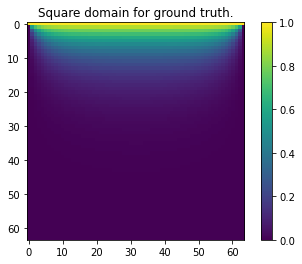

In [13]:
import matplotlib.pyplot as plt

# plot the square domain of ground truth 
ground_truth_square = ground_truth.view(N, N).numpy()

square_fig = plt.figure()
im = plt.imshow(ground_truth_square)
plt.title("Square domain for ground truth.")
plt.colorbar(im)

#square_fig.savefig('../report/figs/square.eps', bbox_inches='tight')
plt.draw()
plt.show()